# Single map correction example NB

## Scope 

- This NB computes XY maps using run 6819 to correct energy and
lifetime.

- Voltage in the anode 7.7 kV!
- New DAQ, lower PMT gain. 


### Author:  JJGC

### Software: KrCalib : https://github.com/nextic/ICAROS/

In [144]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Last updated on  Tue Jan 29 21:39:57 2019


### Logger

In [145]:
import logging


logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

logging.info('Hello world!')


2019-01-29 21:39:58,656 | INFO : Hello world!


### Input files

In [146]:
from krcal.core.kr_types import KrFileName
input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"


run_number  = 6817
first_file  ='0000'
last_file   = 9999
input_file_names  = [f'dst_{run_number}_trigger1_{first_file}_{last_file}.h5']

time_bins = 10
output_file_name  = ' '
map_file_name     = ''
map_file_name_ts  = ''
emap_file_name    = f'kr_emap_xy_100_100_r_{run_number}.h5'


krfn = KrFileName(input_file_names,
                  output_file_name,
                  map_file_name,
                  map_file_name_ts,
                  emap_file_name)

### Notebook configuration

In [147]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [148]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings
sns.set()

In [149]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units
import invisible_cities.reco.corrections      as corrf

In [150]:
from krcal.core.io_functions       import kdst_write
from krcal.core.io_functions       import filenames_from_list
from krcal.core.io_functions       import write_maps
from krcal.core.io_functions       import read_maps
from krcal.core.io_functions       import write_maps_ts
from krcal.core.io_functions       import read_maps_ts

In [151]:
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo

In [152]:
from krcal.core.core_functions      import time_delta_from_time
from krcal.core.core_functions      import phirad_to_deg
from krcal.core.core_functions      import NN
from krcal.core.core_functions      import timeit
from krcal.core                     import fit_functions_ic as fitf

In [153]:
from krcal.core.plt_functions  import plot_sector
from krcal.core.plt_functions  import plot_sectors

In [154]:
from krcal.core.stat_functions      import mean_and_std

In [155]:
from krcal.core.analysis_functions  import kr_ranges_and_bins
from krcal.core.analysis_functions  import fiducial_volumes
from krcal.core.analysis_functions  import fid_eff
from krcal.core.analysis_functions  import select_rphi_sectors
from krcal.core.analysis_functions  import select_xy_sectors
from krcal.core.analysis_functions  import event_map

from krcal.core.analysis_functions  import kr_event_selection
from krcal.core.analysis_functions  import kr_event

In [156]:
from krcal.core.fit_lt_functions    import fit_lifetime
from krcal.core.fit_lt_functions    import time_fcs
from krcal.core.fit_lt_functions    import fit_fcs_in_rphi_sectors
from krcal.core.fit_lt_functions    import fit_fcs_in_xy_bin
from krcal.core.fit_lt_functions    import fit_map_rphi
from krcal.core.fit_lt_functions    import fit_map_xy
from krcal.core.fit_lt_functions    import get_time_series

In [157]:
from krcal.core.fit_lt_histograms   import histo_fit_sectors
from krcal.core.fit_lt_histograms   import print_fit_sectors_pars
from krcal.core.fit_lt_histograms   import plot_fit_sectors
from krcal.core.fit_lt_histograms   import plot_fit_xy
from krcal.core.fit_lt_histograms   import plot_time_fcs
from krcal.core.fit_lt_histograms   import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_histograms   import print_fit_lifetime

In [158]:
from krcal.core.fit_energy_functions    import fit_energy
from krcal.core.fit_energy_functions    import plot_fit_energy
from krcal.core.fit_energy_functions    import print_fit_energy
from krcal.core.fit_energy_functions    import resolution_r_z
from krcal.core.fit_energy_functions    import plot_resolution_r_z

In [159]:
from krcal.core.kr_types import PlotLabels, KrEvent, ASectorMap
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core.kr_types import KrFileName
from krcal.core.kr_types import ASectorMap


In [160]:
from krcal.core.rphi_maps_functions   import draw_rphi_maps
from krcal.core.rphi_maps_functions   import draw_rphi_map
from krcal.core.rphi_maps_functions   import draw_rphi_maps_ts
from krcal.core.rphi_maps_functions   import draw_wedges
from krcal.core.rphi_maps_functions   import define_rphi_sectors
from krcal.core.rphi_maps_functions   import rphi_sector_map_def

In [161]:
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import amap_valid_mask
from krcal.core.map_functions   import amap_valid_fraction
from krcal.core.map_functions   import amap_average
from krcal.core.map_functions   import amap_max
from krcal.core.map_functions   import amap_min
from krcal.core.map_functions   import amap_replace_nan_by_mean
from krcal.core.map_functions   import amap_replace_nan_by_zero
from krcal.core.map_functions   import regularize_maps
from krcal.core.map_functions   import get_maps_from_tsmap
from krcal.core.map_functions   import map_average
from krcal.core.map_functions   import add_mapinfo

In [162]:
from krcal.core.xy_maps_functions   import draw_xy_maps
from krcal.core.xy_maps_functions   import draw_xy_map
from krcal.core.xy_maps_functions   import draw_xy_maps_ts

In [163]:
from krcal.core.s1s2_functions  import energy_time_profile
from krcal.core.s1s2_functions  import energy_X_profile

In [164]:
from krcal.core.correction_functions import e0_rphi_correction
from krcal.core.correction_functions import e0_xy_correction
from krcal.core.correction_functions import lt_xy_correction
from krcal.core.correction_functions import e0_xy_correction_ts
from krcal.core.correction_functions import lt_xy_correction_ts
from krcal.core.correction_functions import lt_rphi_correction
from krcal.core.correction_functions import lt_rphi_correction_ts
from krcal.core.correction_functions import e0_rphi_correction_ts

In [165]:
import krcal.dev.corrections       as corrections 


In [166]:
from numpy import pi, sqrt

In [167]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [168]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

### Logger


- CRITICAL
- ERROR
- WARNING
- INFO
- DEBUG



In [169]:
import logging
log = logging.getLogger()

### Input/output 

In [170]:
fn =filenames_from_list(krfn, input_path, output_path, map_path)

In [171]:
fn

KrFileName(input_file_names=['/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6817_trigger1_0000_9999.h5'], output_file_name='/Users/jjgomezcadenas/Projects/ICDATA/ldst/ ', map_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/', map_file_name_ts='/Users/jjgomezcadenas/Projects/ICDATA/maps/', emap_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_emap_xy_100_100_r_6817.h5')

In [172]:
dst           = load_dsts(fn.input_file_names, "DST", "Events")

In [173]:
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {len(dst)}")

Total number of events: 730303


In [31]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Ranges and binning

In [174]:
RMAX      = 200
RCORE     = 100
s1e_range = (3, 25)
s2e_range = (2000, 14000)
s2q_range = (200, 800)

xy_range  = (-RMAX,  RMAX)
z_range   = (10,  550)
e_range = (5000, 14000)
lt_range = (1000, 6000)
c2_range = (0,5)

krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 50,
                                                        ynbins    = 50,
                                                        znbins    = 15,
                                                        s2enbins  = 25,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

In [175]:
krRanges

KrRanges(S2e=(2000, 14000), S1e=(3, 25), S2q=(200, 800), X=(-200, 200), Y=(-200, 200), Z=(10, 550), T=(1548181483.109, 1548288561.479))

In [176]:
krNbins

KrNBins(S2e=25, S1e=10, S2q=25, X=50, Y=50, Z=15, T=29)

In [177]:
dst = dst[in_range(dst.R, 0, RMAX)]

In [178]:
dst_time = dst.sort_values('time')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

In [179]:
kge = kr_event(dst, DT, dst.S2e, dst.S2q)  # kge = krypton general event; it simply selects a krEvent from the existing DST

```
@dataclass
class KrEvent(Point):
    """Adds raw energy/time"""
    S2e  : Array
    S1e  : Array
    S2q  : Array
    T    : Array  # time
    DT   : Array  # time difference in seconds
    E    : Array
    Q    : Arra`
````

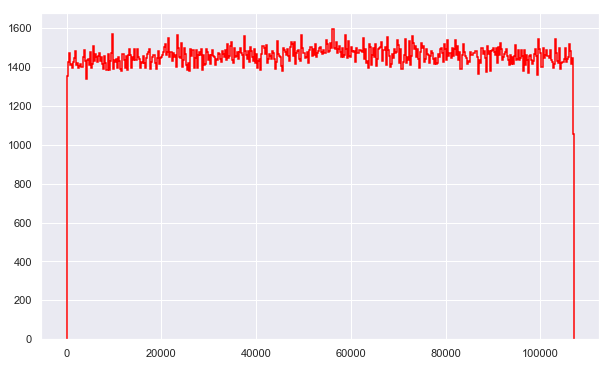

In [180]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(kge.DT, bins=500, range = (kge.DT[0], kge.DT[-1]), color='red', stats=False, lbl='pre-sel')

### Time 

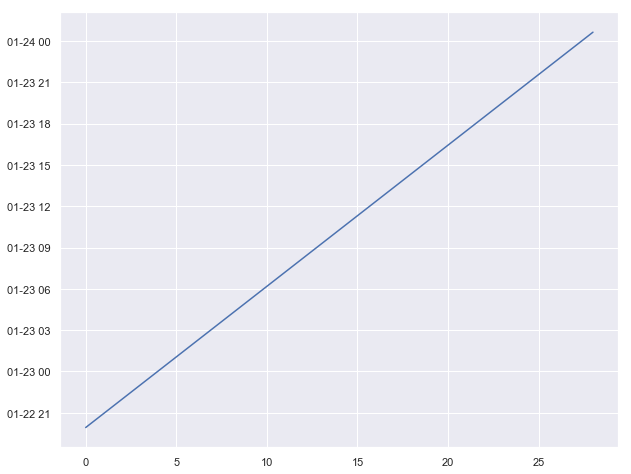

In [181]:
plt.plot(krTimes.timeStamps)

### Event distribution

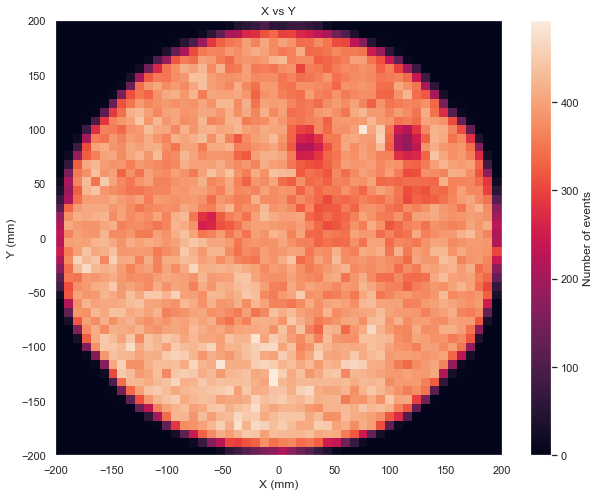

In [182]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y'),
           profile=False,
           figsize=(10,8))

## Time series

### Divide dst in time_bins time series

- Function get_time_series() returns a vector of time series and a an array of masks specifying the events in the time series.

```
def get_time_series(time_bins    : Number,
                    time_range   : Tuple[float, float],
                    kre          : KrEvent)->Tuple[np.array, List[np.array]]:
```


#### Run in debug mode, to view the time series and indexes

In [183]:
log.setLevel(logging.DEBUG)

In [184]:
ts, masks = get_time_series(time_bins, (DT[0],DT[-1]), kge)

2019-01-29 21:41:14,069 | DEBUG : function: get_time_series
2019-01-29 21:41:14,070 | DEBUG :  number of time bins = 10, t_first = 0 t_last = 107078
2019-01-29 21:41:14,071 | DEBUG : indx = [(0, 10707), (10707, 21414), (21414, 32121), (32121, 42828), (42828, 53535), (53535, 64242), (64242, 74949), (74949, 85656), (85656, 96363), (96363, 107070), (96363, 107078)]
2019-01-29 21:41:14,071 | DEBUG : ts = [5353.5, 16060.5, 26767.5, 37474.5, 48181.5, 58888.5, 69595.5, 80302.5, 91009.5, 101716.5, 101720.5]


#### Rerun in normal mode, with time info

In [185]:
log.setLevel(logging.INFO)

In [186]:
ti = timeit(get_time_series)
ts, masks = ti(time_bins, (DT[0],DT[-1]), kge)

Time spent in get_time_series: 0.02179098129272461 s


### Fit lifetime of the time series in the full detector. This is done by the function time_fcs 

```
def time_fcs(ts      : np.array,
             masks   : List[np.array],
             kre     : KrEvent,
             nbins_z : int,
             nbins_e : int,
             range_z : Tuple[float, float],
             range_e : Tuple[float, float],
             energy  : str                 = 'S2e',
             fit     : FitType             = FitType.profile)->FitParTS:

    ````

In [187]:
ti = timeit(time_fcs)
fps = ti(ts, masks, kge, 
         nbins_z = 15,
         nbins_e = 25,
         range_z = (10, 550),
         range_e = (7000, 14000),
         energy  = 'S2e',
         fit     = FitType.profile)  # fps: fit-profile series (implicit is a time series, using profile)

Time spent in time_fcs: 0.19815707206726074 s


#### Repeat using unbined fitting

In [188]:
fus = ti(ts, masks, kge, 
         nbins_z = 15,
         nbins_e = 25,
         range_z = (10, 550),
         range_e = (7000, 14000),
         energy  = 'S2e',
         fit     = FitType.unbined)  # fus: fit-unbined series (implicit is a time series, using unbined)

Time spent in time_fcs: 0.2662239074707031 s


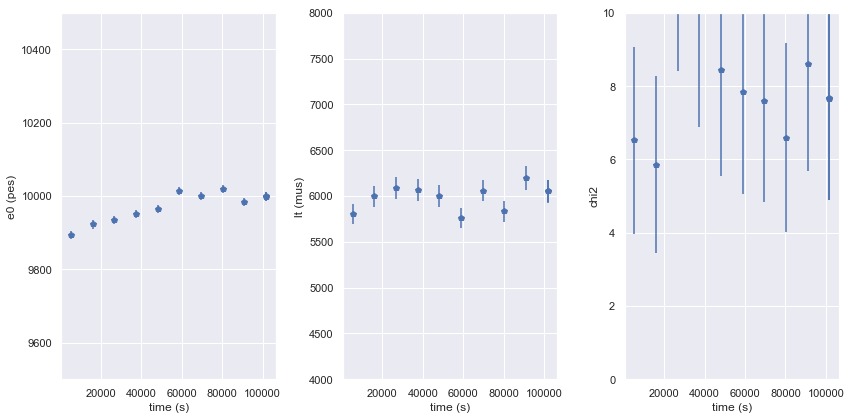

In [192]:
plot_time_fcs(fps,
              range_chi2  = (0,10),
              range_e0    = (9500,10500),
              range_lt    = (4000, 8000),
              figsize     = (12,6))

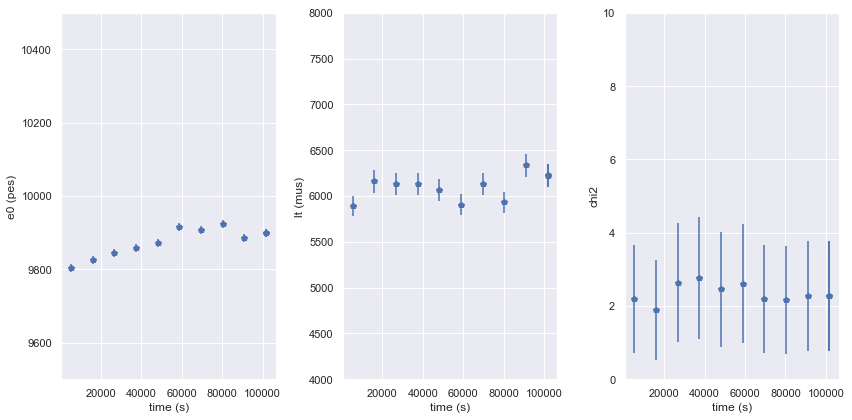

In [193]:
plot_time_fcs(fus,
              range_chi2  = (0,10),
              range_e0    = (9500,10500),
              range_lt    = (4000, 8000),
              figsize     = (12,6))

#### e0 and lt oscilate with time.

- Notice that the oscillation is correlated. 

## Lifetime in RPhi

#### To compute a RPHI map, the first step is to define a KrSector map which contains the definition of the RPHI wedges:

1. Call rphi_sector_map_def():

```
def rphi_sector_map_def(nSectors : int   =10,
                        rmax     : float =200,
                        sphi     : float =45)->RPhiMapDef:
@dataclass
class RPhiMapDef:  # defines the values in (R,Phi) to compute RPHI maps
    r   : Dict[int, Tuple[float, float]] # (rmin, rmax) in each radial sector
    phi : Dict[int, List[Tuple[float, float]]] # (phi_0, ph_1... phi_s) per radial sector
```

2. Call define_rphi_sectors():
```
def define_rphi_sectors(rpmf : RPhiMapDef)-> Dict[int, List[KrSector]]:
    """
    Compute a map (defined as a Dict[int, List[]]) of KrSectors`
```

3. The KrSector map (W) can be drawn (with draw_wedges), and then used to compute selection maps

In [194]:
NSECTORS =5  # number of sectors in R. Each sector then is 200 / 5 = 40 cm.
SPHI     =45 # size of the phi pie-slice in degrees, thus 10 slices in phi.

In [195]:
rpsmd = rphi_sector_map_def(nSectors=NSECTORS, rmax=RMAX, sphi=SPHI)

In [196]:
W = define_rphi_sectors(rpsmd)

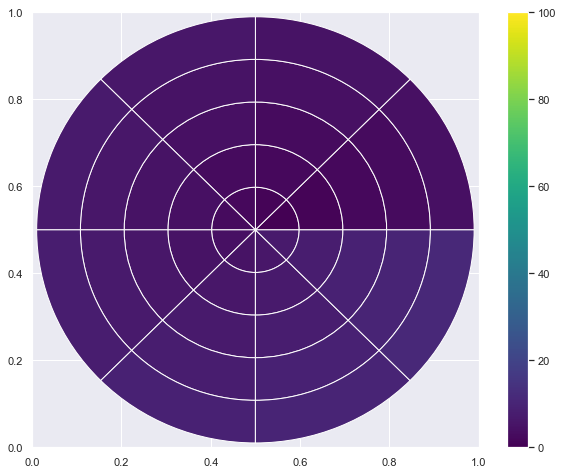

In [197]:
draw_wedges(W,  rmax = RMAX, 
            scale= 0.49, figsize=(10,8), alpha=1.0,
            cr =range(NSECTORS))

#### The next step is to select the RPHI sectors than enter the map.

1.Call select_rphi_sector() to obtain a map of RPHI selections.
```
def select_rphi_sectors(dst     : DataFrame,
                        dt      : np.array,
                        E       : np.array,
                        Q       : np.array,
                        RPS     : Dict[int, List[KrSector]])-> Dict[int, List[KrEvent]]:
    """
    Return a dict of KrEvent organized by rphi sector.

    Parameters
    ----------
        dst:
        The input data frame.

        dt:
        An array of time differences needed to compute the time masks.

        E:
        An energy vector (can contain the corrected energy in the PMTs).

        Q:
        An energy vector (can contain the corrected energy in the SiPMs).

        RPS:
        RPHI selection, a map defining the RPHI wedges.

    Returns
    -------
        A map of selections defined as Dict[int, List[KrEvent]]
        where for each radial sector (the key in the dict) one has a list
        (corresponding to the PHI sectors) of KrEvent (the events selected)

    """
```
2. Make a map of events in each RPHI sector with event_map():
```
def event_map(KRES : Dict[int, List[KrEvent]])->DataFrame:
    """
    Return an event map containing the events in each RPHI sector.

    Parameters
    ----------
        KRES:
        A map of selections (a dictionary of KrEvent).

    Returns
    -------
        A DataFrame containing the events in each RPHI sector.

    """
   

In [198]:
ti = timeit(select_rphi_sectors)
KSRP = ti(dst, DT, dst.S2e, dst.S2q, W) # KSRP: Krypton Selection R-PHI

Time spent in select_rphi_sectors: 1.032663106918335 s


In [199]:
ti = timeit(event_map)
neM = ti(KSRP)   # number of events in Map

Time spent in event_map: 0.0006339550018310547 s


In [200]:
neM

,0,1,2,3,4
0,3626,12008,19630,27892,32979
1,3807,11790,20364,29513,32992
2,3895,11493,19771,28817,32267
3,3610,11278,18859,26701,31391
4,3565,10182,17980,23343,30024
5,3690,10386,16961,25712,26829
6,3880,11403,19296,26747,26997
7,3733,10420,19086,26454,29096


#### The number of events in the map can be represented by a heat map

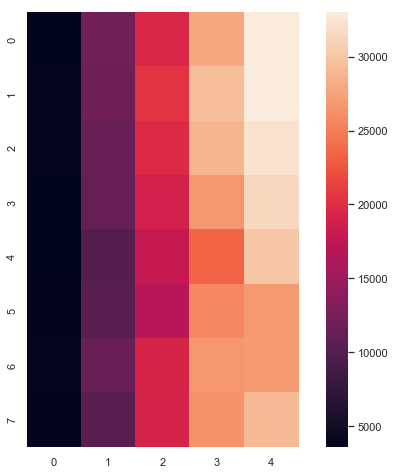

In [201]:
ax = sns.heatmap(neM, square=True)

### One can now fit the lifetime in RPHI sectors (in time bins)

```
def fit_fcs_in_rphi_sectors(sector        : int,
                            selection_map : Dict[int, List[KrEvent]],
                            event_map     : DataFrame,
                            n_time_bins   : int,
                            time_diffs    : np.array,
                            nbins_z       : int,
                            nbins_e       : int,
                            range_z       : Tuple[float, float],
                            range_e       : Tuple[float, float],
                            energy        : str                 = 'S2e',
                            fit           : FitType             = FitType.profile,
                            n_min         : int                 = 100)->List[FitParTS]:
    """
    Returns fits to a (radial) sector of a RPHI-time series map

        Parameters
        ----------
            sector
                Radial sector where the fit is performed.
            selection_map
                A map of selected events defined as Dict[int, List[KrEvent]]
            event_map
                An event map defined as a DataFrame
            n_time_bins
                Number of time bins for the time series.
            time_diffs
                Vector of time differences for the time series.
            nbins_z
                Number of bins in Z for the fit.
            nbins_e
                Number of bins in energy.
            range_z
                Range in Z for fit.
            range_e
                Range in energy.
            energy:
                Takes two values: S2e (uses S2e field in kre) or E (used E field on kre).
                This field allows to select fits over uncorrected (S2e) or corrected (E) energies.
            fit
                Selects fit type.
            n_min
                Minimum number of events for fit.

        Returns
        -------
            A List[FitParTS], one FitParTs per PHI sector.

        @dataclass
        class FitParTS:             # Fit parameters Time Series
            ts   : np.array          # contains the time series (integers expressing time differences)
            e0   : np.array          # e0 fitted in time series
            lt   : np.array
            c2   : np.array
            e0u  : np.array          # e0 error fitted in time series
            ltu  : np.array
            
    """
```

In [202]:
erange = (0,14000)
ltrange = (0, 7000)
# frs --> fit radial sectors 

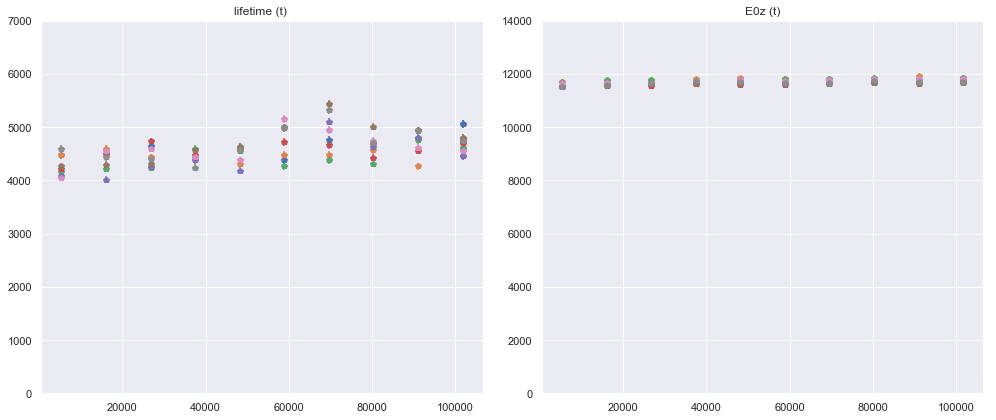

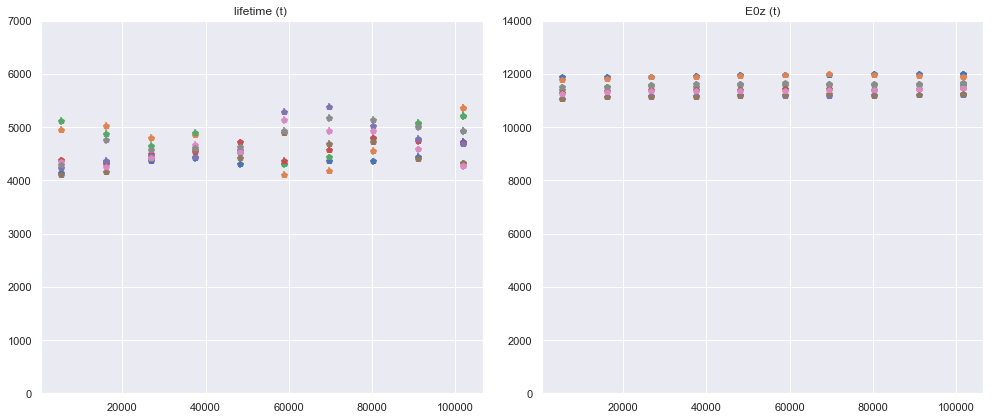

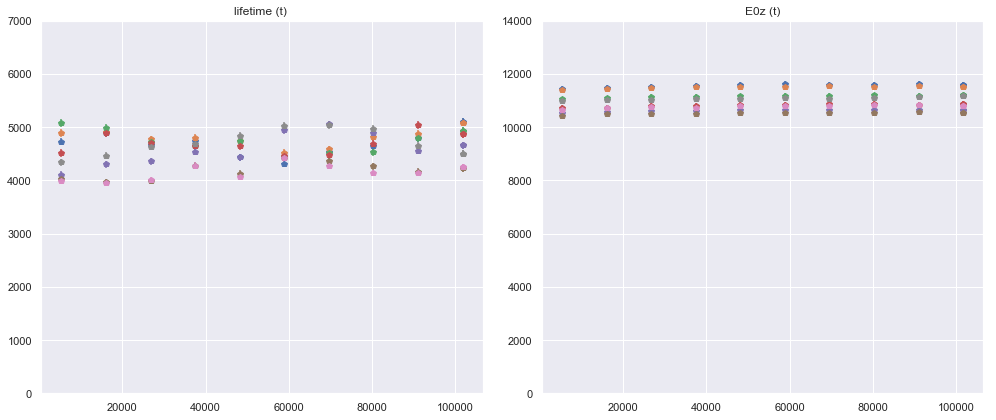

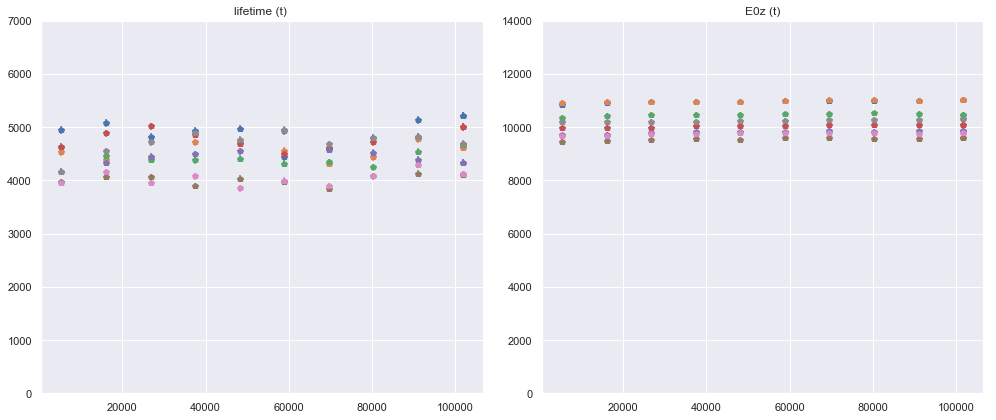

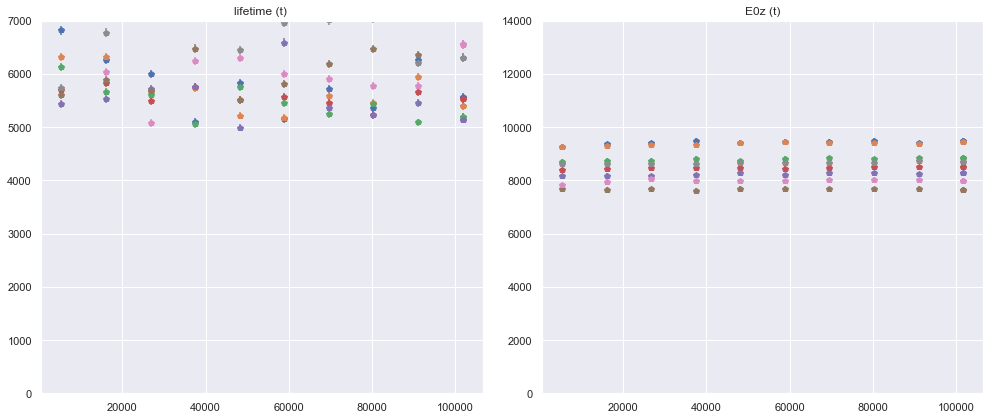

In [203]:
for sector in range(NSECTORS):
    frs = fit_fcs_in_rphi_sectors(sector = sector,
                                  selection_map = KSRP,
                                  event_map     = neM,
                                  n_time_bins   = time_bins,
                                  time_diffs    =DT,
                                  nbins_z       = 25,
                                  nbins_e       = 50,
                                  range_z       =(50, 550),
                                  range_e       = (5000, 14500),
                                  energy        = 'S2e',
                                  fit           = FitType.unbined,
                                  n_min         = 100)
    plot_fit_sectors(frs,  range_e0 =erange, range_lt=ltrange)
    

### Lifetime patterns:

- Oscillatory pattern (in time) across the run, increases with radial sector, lifetime in this run appears to increase slightly. 
- All phi sectors seem to oscillate with the same wavelength.
- All R sectors are rather uniform. 
- R > 160 cm data shows very high and very variable lifetime, with a spread of several ms.

## Single time XY map. 

- Compute a single-time (or time-averaged) map, with a fine-grain in XY. 
- The energy map (e0 correction) is invariant and can be added for many maps.
- The lt map (lt correction) represents an average-over-run. A correction function may use such a map or add a time-dependent correction, fitting the time dependence. 

## Divide chamber in sectors of XY
```
def select_xy_sectors(dst        : DataFrame,
                      time_diffs : np.array,
                      E          : np.array,
                      Q          : np.array,
                      bins_x     : np.array,
                      bins_y     : np.array)-> Dict[int, List[KrEvent]]:
    """
    Return a dict of KrEvent organized by xy sector
```

In [204]:
log.setLevel(logging.INFO) # turn to DEBUG to follow progress of this part 

In [205]:
ti = timeit(select_xy_sectors)
KXY = ti(dst, DT, dst.S2e.values, dst.S2q.values, krBins.X, krBins.Y)

Time spent in select_xy_sectors: 8.343649625778198 s


In [206]:
log.setLevel(logging.INFO)

In [207]:
nXY = event_map(KXY)

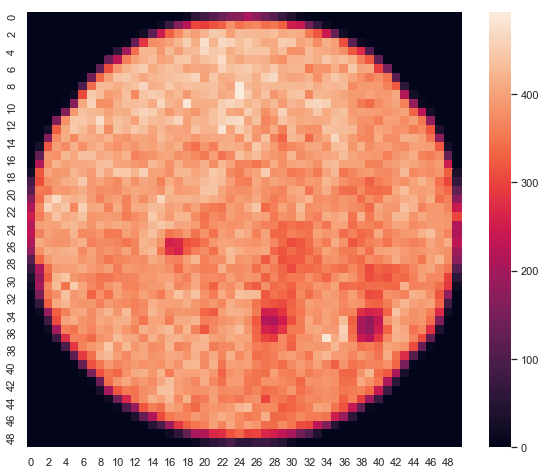

In [208]:
ax = sns.heatmap(nXY, square=True)

## Fits in XY sectors

## Maps

#### The first step is to fit a map XY (in time series) for the number of time bins required (in this case 1)
```
def fit_map_xy(selection_map : Dict[int, List[KrEvent]],
               event_map     : DataFrame,
               n_time_bins   : int,
               time_diffs     : np.array,
               nbins_z       : int,
               nbins_e       : int,
               range_z       : Tuple[float, float],
               range_e       : Tuple[float, float],
               energy        : str                 = 'S2e',
               fit           : FitType             = FitType.profile,
               n_min         : int                 = 100)->Dict[int, List[FitParTS]]:
 ```

In [209]:
ti = timeit(fit_map_xy)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fmxy = ti(selection_map = KXY,
              event_map     = nXY,
              n_time_bins   = 1,
              time_diffs    = DT,
              nbins_z        = krNbins.Z, 
              nbins_e        = krNbins.S2e, 
              range_z        = z_range, 
              range_e        = e_range,
              energy        = 'S2e',
              fit           = FitType.unbined,
              n_min         = 100)


Time spent in fit_map_xy: 6.0989649295806885 s


#### The second step is to obtain the maps themselves from the fit-map-XY
```
def tsmap_from_fmap(fMap : Dict[int, List[FitParTS]])->SectorMapTS:
    """
    Obtain a time-series of maps (tsmap) from a fit-map (fmap).

    Parameters
    ----------
    fMap
        A Dictionary (key = R sector for Rphi maps, X for XYmaps) containing a list of FitParTS
        (list runs over Phi wedges for RPhi maps, Y for Ymaps)
        class ASectorMap:
            chi2  : DataFrame
            e0    : DataFrame
            lt    : DataFrame
            e0u   : DataFrame
            ltu   : DataFrame

            class FitParTS:
                ts   : np.array -> contains the time series (integers expressing time differences)
                e0   : np.array ->e0 fitted in time series
                lt   : np.array
                c2   : np.array
                e0u  : np.array
                ltu  : np.array

    Returns
    -------
    SectorMapTS : Maps in chamber sector containing time series of parameters
        class SectorMapTS:
            chi2  : Dict[int, List[np.array]]
            e0    : Dict[int, List[np.array]]
            lt    : Dict[int, List[np.array]]
            e0u   : Dict[int, List[np.array]]
            ltu   : Dict[int, List[np.array]]

    """
```

In [210]:
ti = timeit(tsmap_from_fmap)
tsm = ti(fmxy)

Time spent in tsmap_from_fmap: 0.0012378692626953125 s


#### Third step: select the corresponding map in the time series (in this case just one, ts=0)
```
def amap_from_tsmap(tsMap      : SectorMapTS,
                    ts         : int  = 0,
                    range_e    : Tuple[float, float] = (5000, 13000),
                    range_chi2 : Tuple[float, float] = (0,3),
                    range_lt   : Tuple[float, float] = (1800, 3000)) ->ASectorMap:
    """
    Obtain the correction maps for time bin ts.

    Parameters
    ----------
    tsMap
        A SectorMapTS : Maps in chamber sector containing time series of parameters
        class SectorMapTS:
            chi2  : Dict[int, List[np.array]]
            e0    : Dict[int, List[np.array]]
            lt    : Dict[int, List[np.array]]
            e0u   : Dict[int, List[np.array]]
            ltu   : Dict[int, List[np.array]]
    ts
        time bin (an integer starting at 0: if -1 take the average of the series).
    range_e
        Defines the range of e in pes (e.g, (8000,14000)).
    range_chi2
        Defines the range of chi2
    range_lt
        Defines the range of lt in mus.

    Returns
    -------
    A container of maps ASectorMap
        class ASectorMap:
            chi2  : DataFrame
            e0    : DataFrame
            lt    : DataFrame
            e0u   : DataFrame
            ltu   : DataFrame

    """
```


In [211]:
am = amap_from_tsmap(tsm, 
                     ts = 0, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)

#### Am contains the maps in XY bins for the single time series (ts=0). We can now compute the map average, draw, etc:

In [212]:
amap_average(am) 

ASectorMap(chi2=0.9868500732695245, e0=9838.504693189056, lt=4317.797814102642, e0u=29.00779410768804, ltu=168.69754459799654, mapinfo=None)

#### Get rid of outlayers that distort mean and error

In [213]:
rmap = regularize_maps(am, erange=e_range, ltrange=lt_range)

2019-01-30 09:20:58,303 | INFO :  set nans to average value of interval = 9500.0
2019-01-30 09:20:58,357 | INFO :  set nans to average value of interval = 3500.0


In [214]:
amap_average(rmap)

ASectorMap(chi2=0.9868500732695245, e0=9838.504693189056, lt=4317.797814102642, e0u=29.00779410768804, ltu=168.69754459799654, mapinfo=None)

In [215]:
asm = relative_errors(rmap)

In [216]:
amv = amap_average(asm)
amv

ASectorMap(chi2=0.9868500732695245, e0=9838.504693189056, lt=4317.797814102642, e0u=0.30892196330433014, ltu=3.997425201485921, mapinfo=None)

#### Draw the maps using default colormap

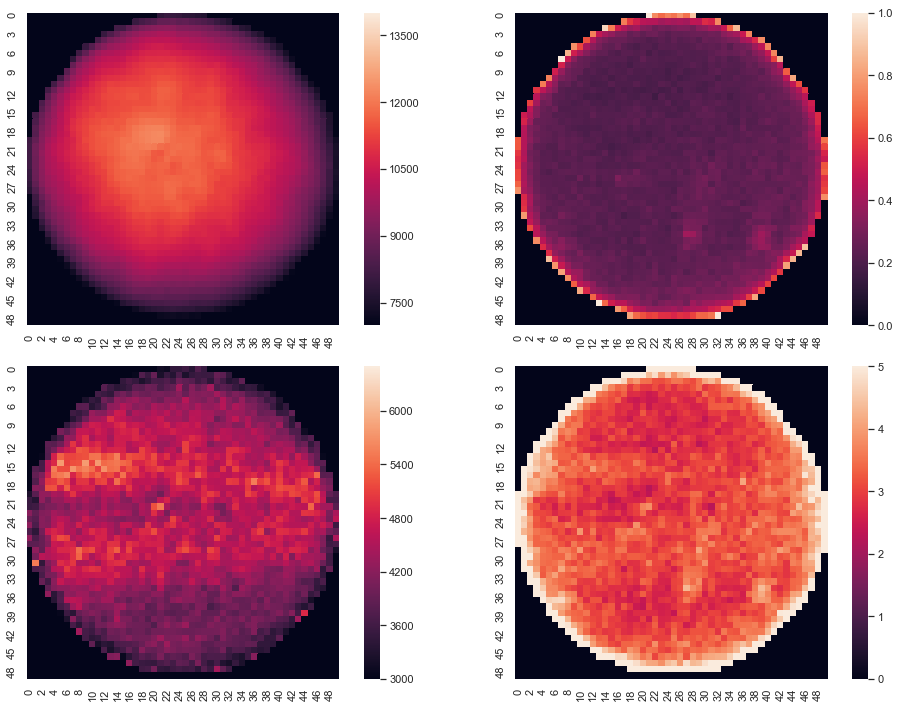

In [217]:
draw_xy_maps(asm,
            e0lims  = (7000, 14000),
            ltlims  = (3000, 6500),
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

#### The dark spots correspond to regions of low statistic, where the fits did not work. To avoid this effect, it is necessary to use more statistic for the XY maps. 

In [218]:
asmAv = amap_replace_nan_by_mean(asm, amMean=amv)

In [219]:
amap_average(asmAv)

ASectorMap(chi2=0.9824084181609137, e0=10014.968953337184, lt=4340.184644671201, e0u=0.2935045446770456, ltu=3.7600576354547917, mapinfo=None)

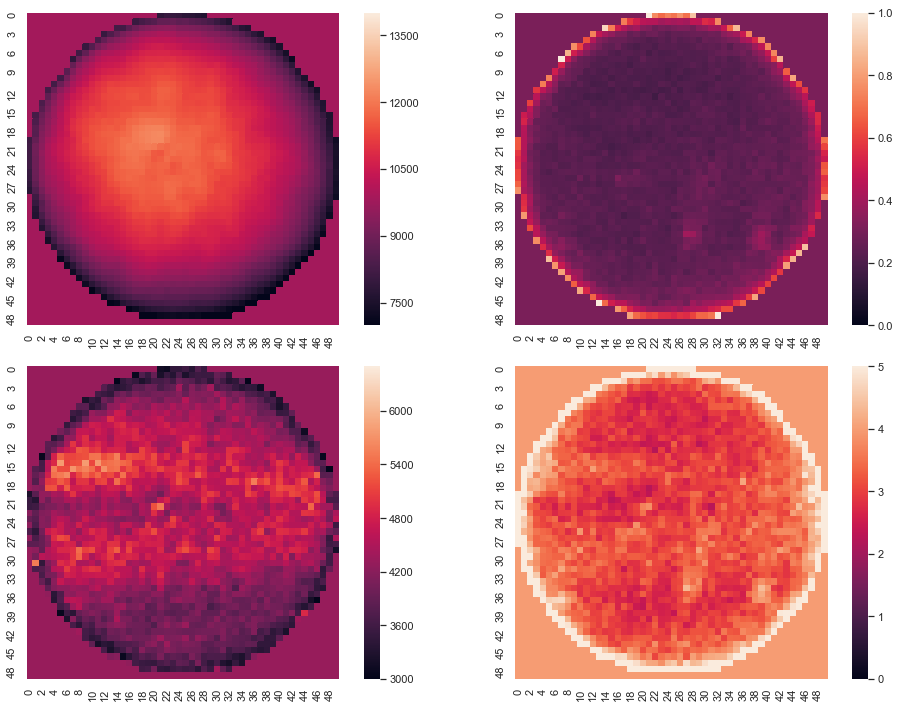

In [220]:
draw_xy_maps(asmAv,
            e0lims  = (7000, 14000),
            ltlims  = (3000, 6500),
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

In [221]:
asm = add_mapinfo(asmAv, krRanges.X, krRanges.Y, krNbins.X, krNbins.Y, run_number)

In [222]:
asm.mapinfo

xmin          -200
xmax           200
ymin          -200
ymax           200
nx              50
ny              50
run_number    6817
dtype: int64

### Save to file

In [223]:
write_maps(asm, filename=fn.emap_file_name)

### Read back

In [224]:
fn.emap_file_name

'/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_emap_xy_100_100_r_6817.h5'

In [225]:
emaps = read_maps(filename=fn.emap_file_name)

In [226]:
emaps.mapinfo

xmin          -200
xmax           200
ymin          -200
ymax           200
nx              50
ny              50
run_number    6817
dtype: int64

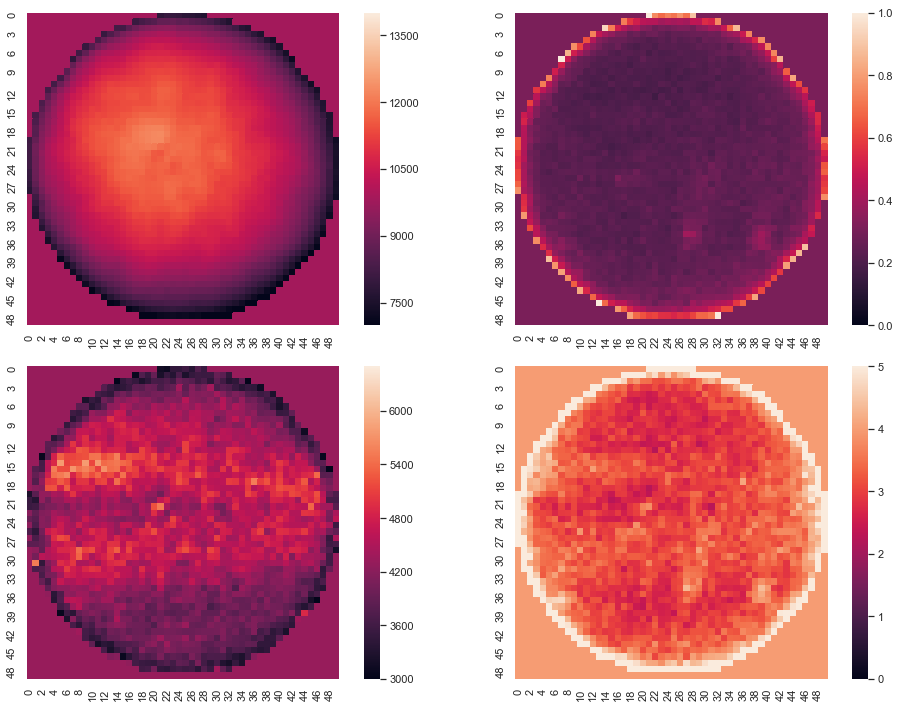

In [227]:
draw_xy_maps(emaps,
            e0lims  = (7000, 14000),
            ltlims  = (3000, 6500),
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

## Now check the corrections that can be achieved with the single maps

In [228]:
amap_average(emaps)

ASectorMap(chi2=0.9824084181609137, e0=10014.968953337184, lt=4340.184644671201, e0u=0.2935045446770456, ltu=3.7600576354547917, mapinfo=None)

In [229]:
norm = amap_max(emaps)

In [230]:
norm

ASectorMap(chi2=28.151101604299807, e0=12289.57975640193, lt=5779.4767114591805, e0u=1.2066850917730194, ltu=19.90755073419182, mapinfo=None)

#### E0 correction:
```
def e0_xy_correction(E   : np.array,
                     X   : np.array,
                     Y   : np.array,
                     E0M : DataFrame,
                     xr  : Tuple[int, int],
                     yr  : Tuple[int, int],
                     nx  : int,
                     ny  : int)->np.array:
    """
    Computes the energy vector corrected by geometry in bins of XY.

    Parameters
    ----------
    E
        The uncorrected energy vector.
    X
        Array of X bins.
    Y
        Array of Y bins.
    E0M
        Map of geometrical corrections (E0 map).
    xr
        Range of X (e.g, (-220,220)).
    yr
        Range of Y (e.g, (-220,220)).
    nx
        Number of bins in X.
    ny
        Number of bins in Y.

    Returns
    -------
    np.array
        The corrected energy vector (by energy).

    """
```


In [231]:
ti = timeit(e0_xy_correction)
E0 = ti(dst.S2e.values,
        dst.X.values,
        dst.Y.values,
        E0M = emaps.e0 / norm.e0, 
        xr  = krRanges.X,
        yr  = krRanges.Y,
        nx  = krNbins.X, 
        ny  = krNbins.Y)

Time spent in e0_xy_correction: 6.8135528564453125 s


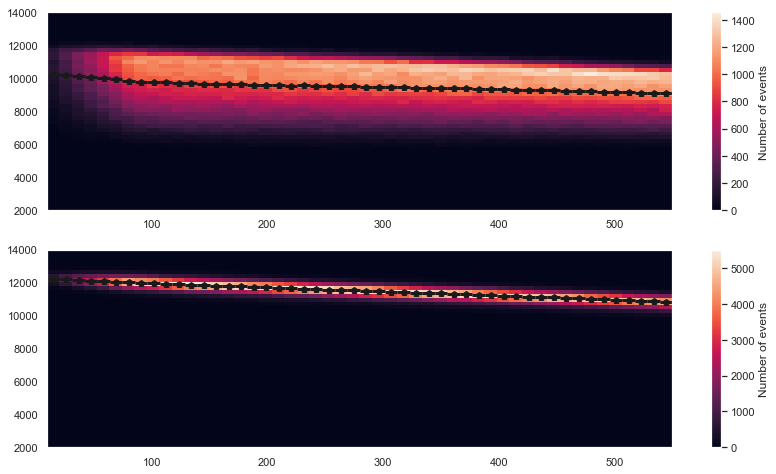

In [232]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(2, 1, 1)
nevt = h2(dst.Z, dst.S2e, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)
ax      = fig.add_subplot(2, 1, 2)
nevt = h2(dst.Z, E0, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)

#### To see the effect of the E0 correction, we can now recompute the RPHI maps. 

In [233]:
ti = timeit(select_rphi_sectors)
KRP = ti(dst, DT, E0, dst.S2q, W) # Passing now the E0 vector to the kre_event

Time spent in select_rphi_sectors: 0.8257231712341309 s


In [234]:
neM = event_map(KRP)

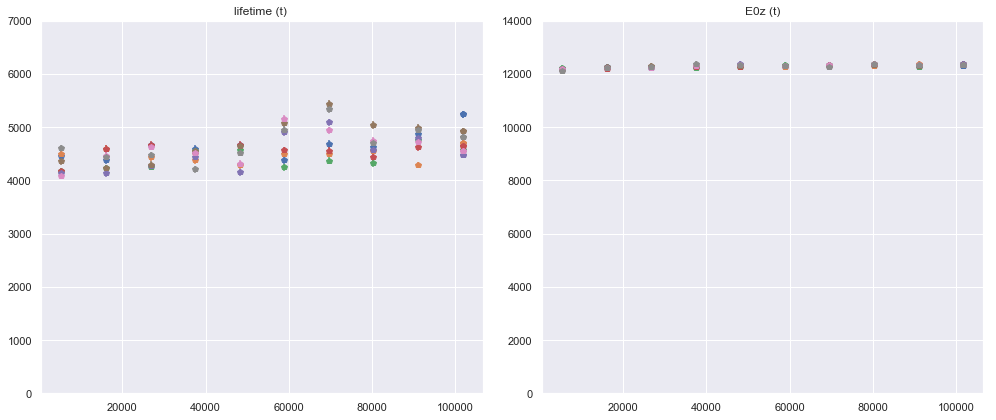

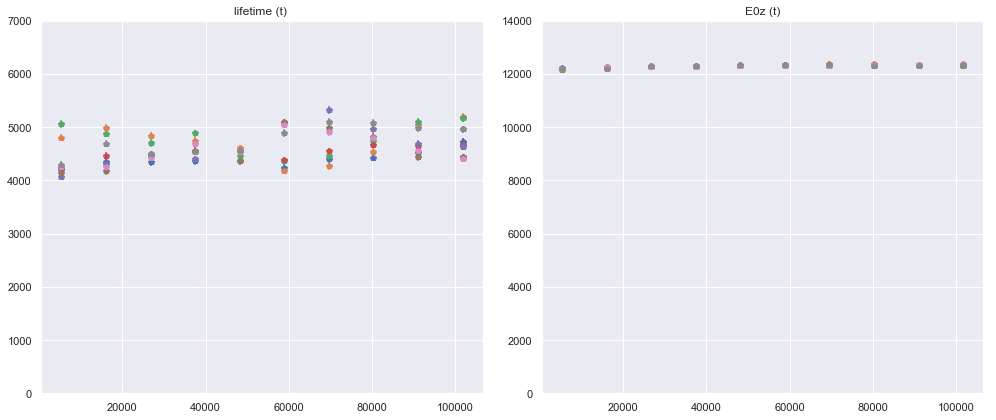

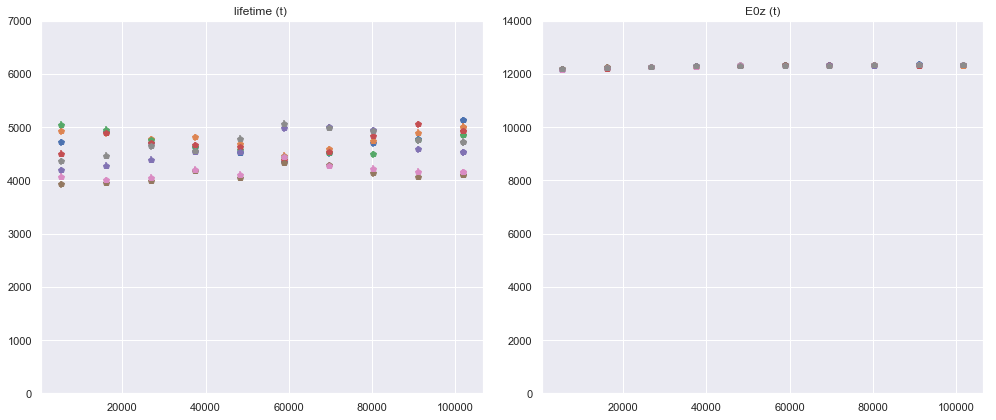

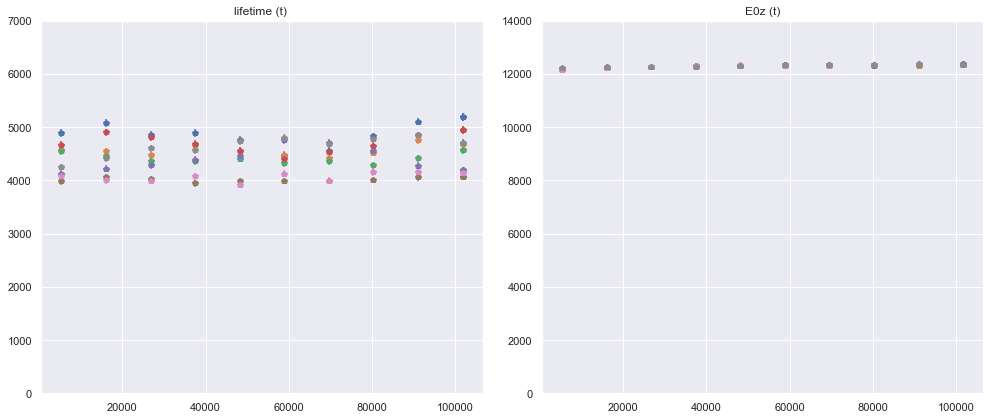

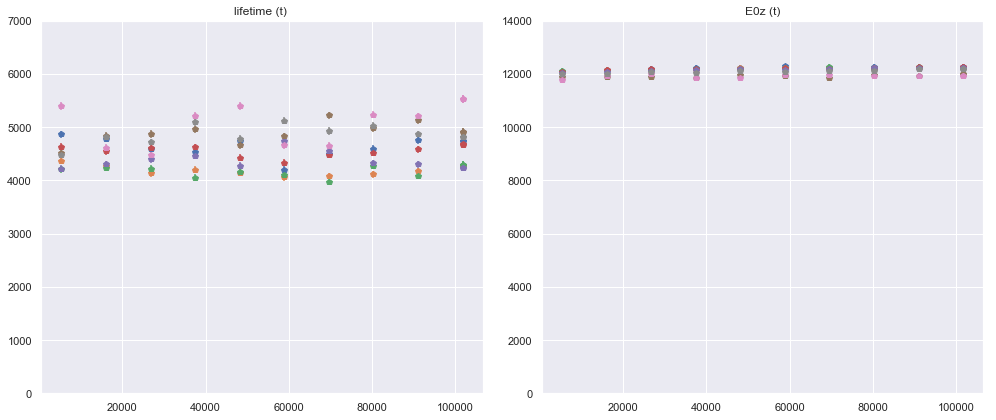

In [235]:
for sector in range(NSECTORS):
    frs = fit_fcs_in_rphi_sectors(sector = sector,
                                  selection_map = KRP,
                                  event_map     = neM,
                                  n_time_bins   = time_bins,
                                  time_diffs    =DT,
                                  nbins_z       = 25,
                                  nbins_e       = 50,
                                  range_z       =(50, 550),
                                  range_e       = (5000, 15500),
                                  energy        = 'E',                        #use corrected energy
                                  fit           = FitType.unbined,
                                  n_min         = 100)
    plot_fit_sectors(frs,  range_e0 =erange, range_lt=ltrange)
    

#### And also the explicit RPHI maps

In [236]:
ti = timeit(fit_map_rphi)
fmrp = ti(selection_map    = KRP,
          event_map     = neM,
          n_time_bins   = time_bins,
          time_diffs    = DT,
          nbins_z       = krNbins.Z, 
          nbins_e       = krNbins.S2e, 
          range_z       = z_range, 
          range_e       = e_range,
          energy        = 'E',
          fit           = FitType.unbined,
          n_min         = 100)
t1 = time.time()


Time spent in fit_map_rphi: 1.3827059268951416 s


In [237]:
tsmrp = tsmap_from_fmap(fmrp)

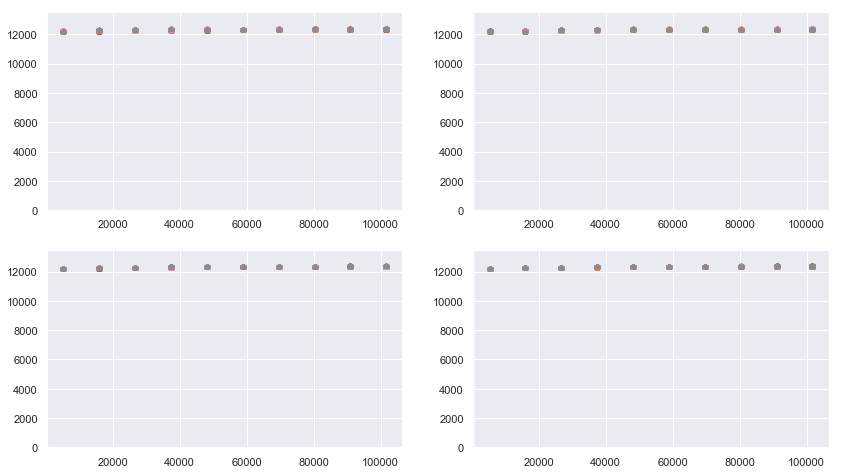

In [238]:
erange=(0, 13500)
fig = plt.figure(figsize=(14,8))
for j in range(0,4):
    ax      = fig.add_subplot(2, 2, j+1)
    for i in neM.index:
        plt.errorbar(ts, tsmrp.e0[j][i], np.sqrt(tsmrp.e0[j][i]), fmt="p")
        plt.ylim(erange)

#### Notice that E0 correction has leveled all the sectors

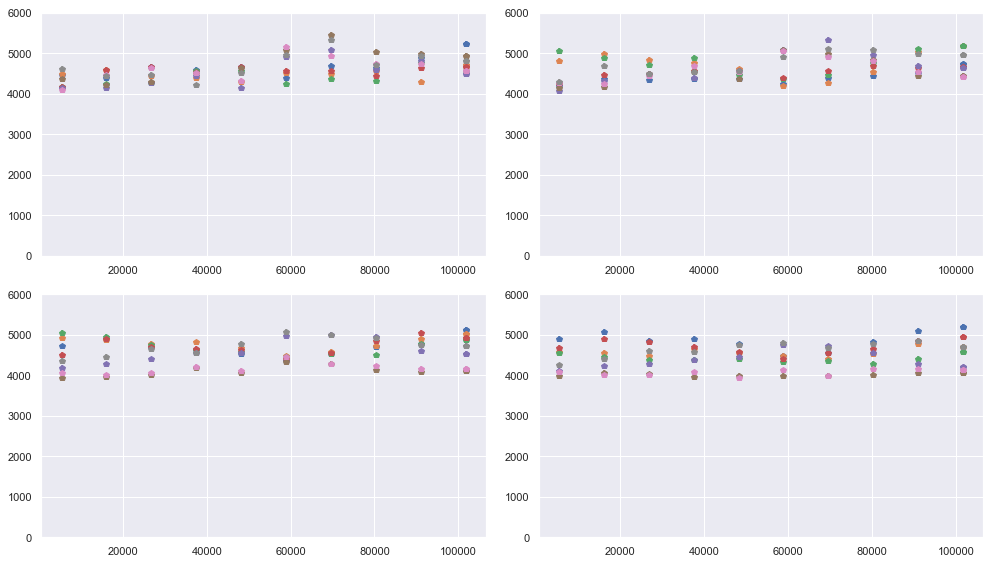

In [239]:
fig = plt.figure(figsize=(14,8))
ltrange=(0, 6000)
for j in range(0,4):
    ax      = fig.add_subplot(2, 2, j+1)
    for i in neM.index:
        plt.errorbar(ts, tsmrp.lt[j][i], np.sqrt(tsmrp.lt[j][i]), fmt="p")
        plt.ylim(ltrange)
plt.tight_layout()

#### RPHI map average (in time)

In [240]:
amts0 = amap_from_tsmap(tsmrp, 
                        ts = 0, 
                        range_e     = e_range,
                        range_chi2  = c2_range,
                         range_lt    = lt_range)

In [241]:
avam = amap_average(amts0) 
avam

ASectorMap(chi2=0.9341269642269033, e0=12144.11577089925, lt=4427.126125220771, e0u=18.50035549818886, ltu=87.61395815388792, mapinfo=None)

In [242]:
asm0 = relative_errors(amts0)

In [243]:
amap_average(asm0) 

ASectorMap(chi2=0.9341269642269033, e0=12144.11577089925, lt=4427.126125220771, e0u=0.1525880543313202, ltu=1.959112617686111, mapinfo=None)

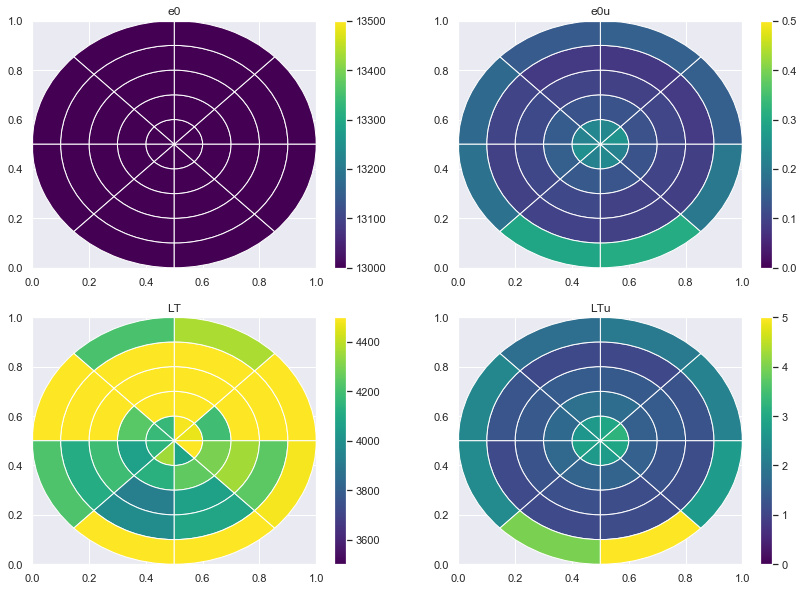

In [244]:
draw_rphi_maps(W, asm0,  
          e0lims  = (13000, 13500),
          ltlims  = (3500, 4500),
          eulims  = (0, 0.5),
          lulims  = (0,5),
          rmax=RMAX, 
          scale=0.5,
          alpha   = 1.0,  
          figsize=(14,10))

### Maps for the full time series

In [248]:
aMaps = []
EE    = []
LT    = []
TT    = []
t0 = time.time()
for i, tt in enumerate(ts):
    am = amap_from_tsmap(tsmrp, 
                         ts = i, 
                         range_e     = (5000, 13000),
                         range_chi2  = (0,100),
                         range_lt    = (2000,7000))
    amv = amap_average(am) 
    asm = relative_errors(am)
    av = amap_replace_nan_by_mean(asm, amMean=amv)
    av0 = amap_average(av) 
    aMaps.append(av)
    EE.append(av0.e0)
    LT.append(av0.lt)
    TT.append(tt)
t1 = time.time()
print(f' t = {t1 -t0}')

 t = 0.16832208633422852


(0, 13500)

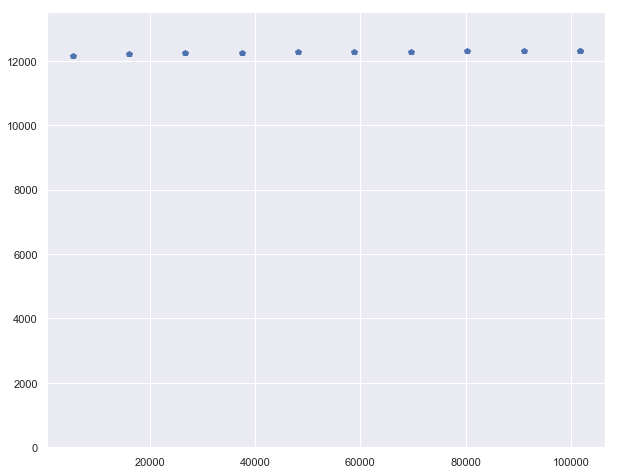

In [249]:
plt.errorbar(TT, EE, 10, fmt="p")
plt.ylim(0,13500)

(4000, 5500)

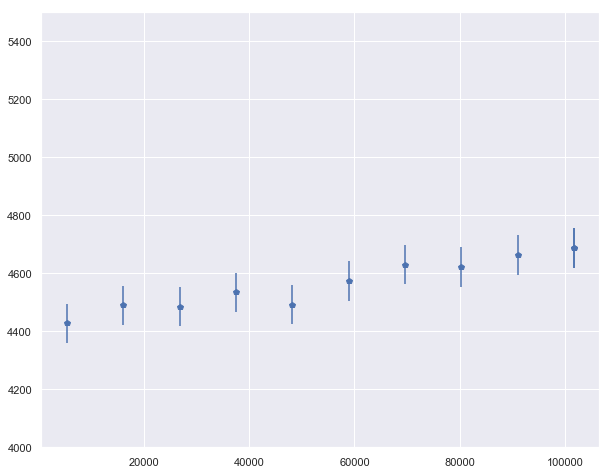

In [250]:
plt.errorbar(TT, LT, sqrt(LT), fmt="p")
plt.ylim(4000,5500)

#### Plot above is the average evolution of lifetime with time across the run.

## XY (single time) LT correction


```
def lt_xy_correction(E    : np.array,
                     X    : np.array,
                     Y    : np.array,
                     Z    : np.array,
                     LTM  : DataFrame,
                     xr   : Tuple[int, int],
                     yr   : Tuple[int, int],
                     nx   : int,
                     ny   : int)->np.array:
    """
    Computes the energy vector corrected by lifetime in bins of XY.

    Parameters
    ----------
    E
        The uncorrected energy vector.
    X
        Array of X bins.
    Y
        Array of Y bins.
    LTM
        Map of lifetime corrections (LT map).
    xr
        Range of X (e.g, (-220,220)).
    yr
        Range of Y (e.g, (-220,220)).
    nx
        Number of bins in X.
    ny
        Number of bins in Y.

    Returns
    -------
    np.array
        The corrected energy vector (by lifetime).

    """
```


In [251]:
ti = timeit(lt_xy_correction)
E = ti(E0, 
       dst.X.values, 
       dst.Y.values,
       dst.Z.values, 
       LTM = emaps.lt,
       xr  = krRanges.X,
       yr  = krRanges.Y,
       nx  = krNbins.X, 
       ny  = krNbins.Y)


Time spent in lt_xy_correction: 6.999835968017578 s


In [252]:
krRanges.S2e

(2000, 14000)

In [253]:
er = (5000,15000)

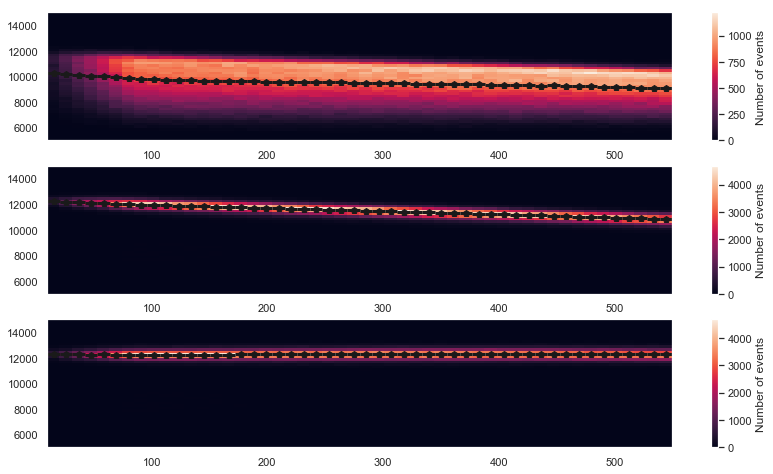

In [254]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(3, 1, 1)
nevt = h2(dst.Z, dst.S2e, 50, 50, krRanges.Z, er, 
           profile=True)
ax      = fig.add_subplot(3, 1, 2)
nevt = h2(dst.Z, E0, 50, 50, krRanges.Z, er, 
           profile=True)
ax      = fig.add_subplot(3, 1, 3)
nevt = h2(dst.Z, E, 50, 50, krRanges.Z, er, 
           profile=True)

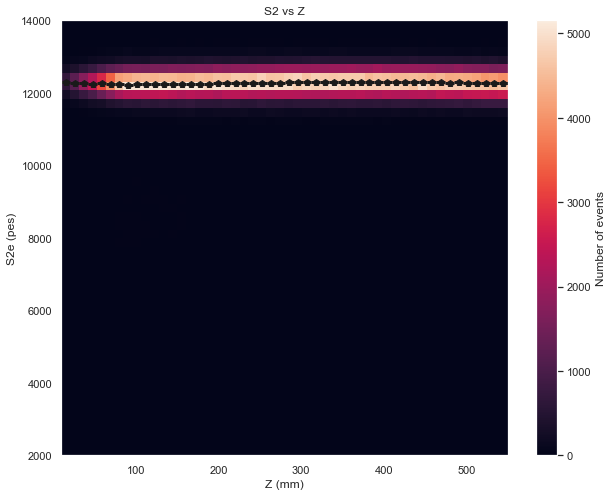

In [255]:
nevt = h2d(dst.Z, E, 50, 50, krRanges.Z, (2000,14000),  
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

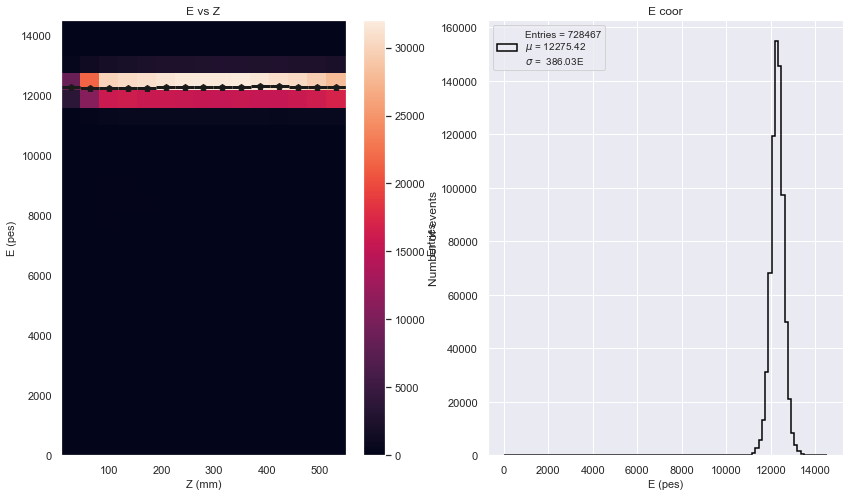

In [256]:
e_range = (0, 14500)
zrange = (10,550)
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dst.Z, E, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(E,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12293.096586133179 +-0.32550108100253283 
 E sigma   = 272.88632882671925 +-0.2558089065811398 
 chi2    = 10.630038128159836 
 sigma E/E (FWHM)     (%) =5.216609730913269
 sigma E/E (FWHM) Qbb (%) =0.6737353522309909 


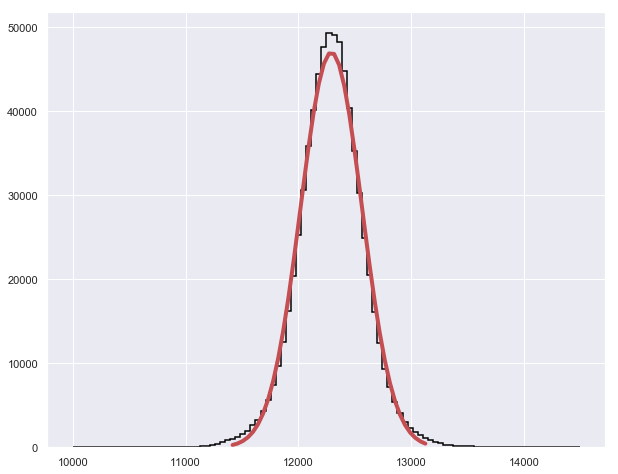

In [257]:
fc = fit_energy(E, nbins=100, range=(10000, 14500))
plot_fit_energy(fc)
print_fit_energy(fc)

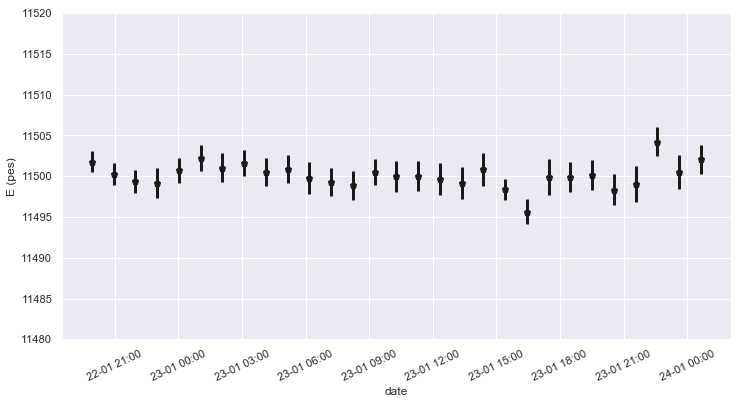

In [258]:
baseline = 11500
shift = 20
e1 = baseline - shift
e2 = baseline + shift
energy_time_profile(T, E, krNbins.T, krRanges.T, krTimes.timeStamps, 
                    erange=(e1, e2),
                    figsize=(12,6))

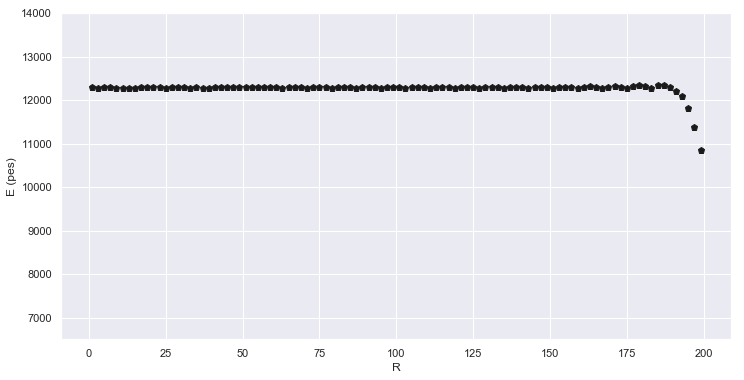

In [259]:
energy_X_profile(dst.R, E, xnbins = 100, xrange=(0,200), xlabel = 'R',
                 erange=(6500, 14000),  
                 figsize=(12,6))

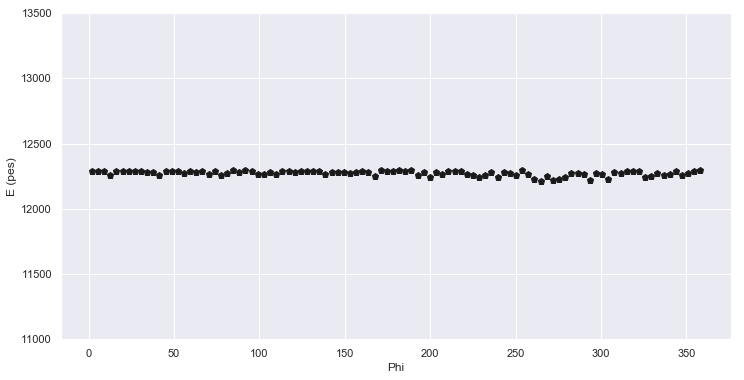

In [260]:
energy_X_profile(phirad_to_deg(dst.Phi), E, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(11000, 13500),  
                 figsize=(12,6))

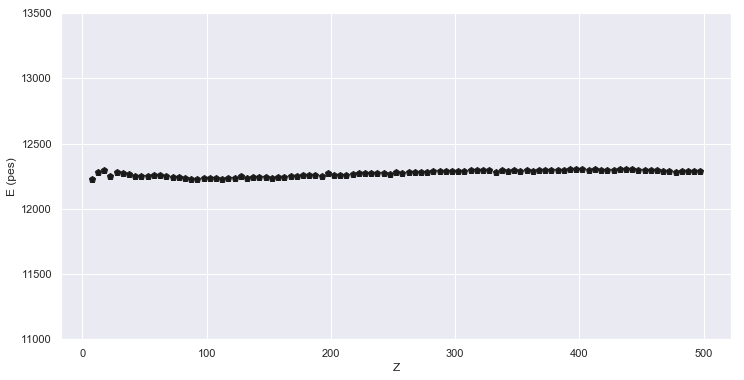

In [261]:
energy_X_profile(dst.Z, E, xnbins = 100, xrange=(0,500), xlabel = 'Z',
                 erange=(11000, 13500),   
                 figsize=(12,6))

### Select events in the region

- R < 180
- 10 < z < 550
- 11000 < E < 13500

In [262]:
rrange = (0, 180)
sel = in_range(dst.R, *rrange) & in_range(dst.Z, *z_range) &  in_range(E, *e_range)

In [263]:
kse = kr_event(dst, DT, E, dst.S2q, sel)  # kse = krypton selected event

### Repeat profles

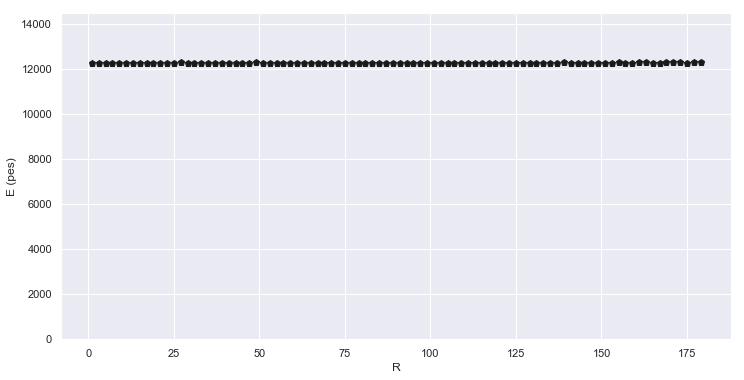

In [264]:
energy_X_profile(kse.R, kse.E, xnbins = 100, xrange=(0,200), xlabel = 'R',
                 erange=e_range,  
                 figsize=(12,6))

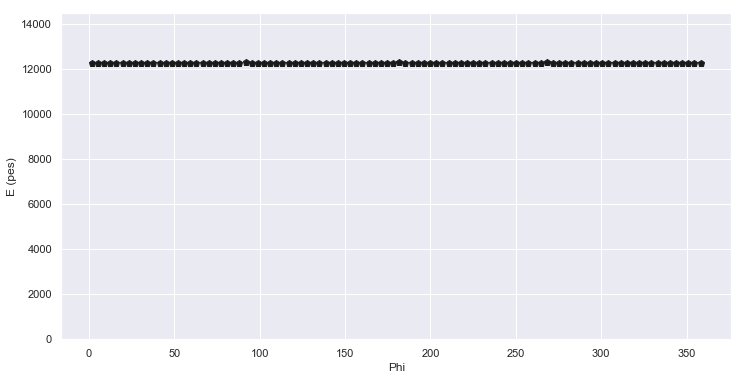

In [265]:
energy_X_profile(phirad_to_deg(kse.Phi), kse.E, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=e_range,  
                 figsize=(12,6))

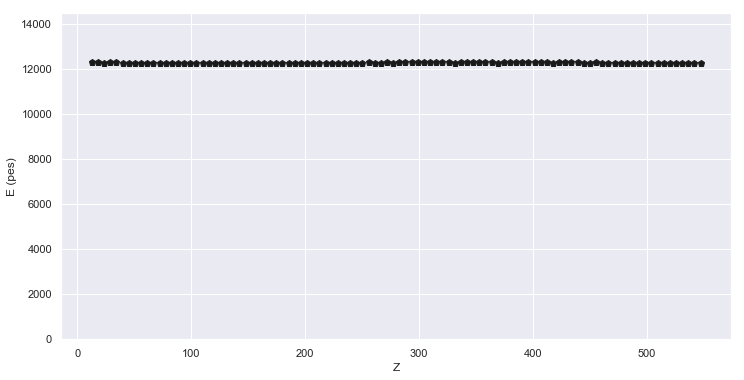

In [266]:
energy_X_profile(kse.Z, kse.E, xnbins = 100, xrange=zrange, xlabel = 'Z',
                 erange=e_range,   
                 figsize=(12,6))

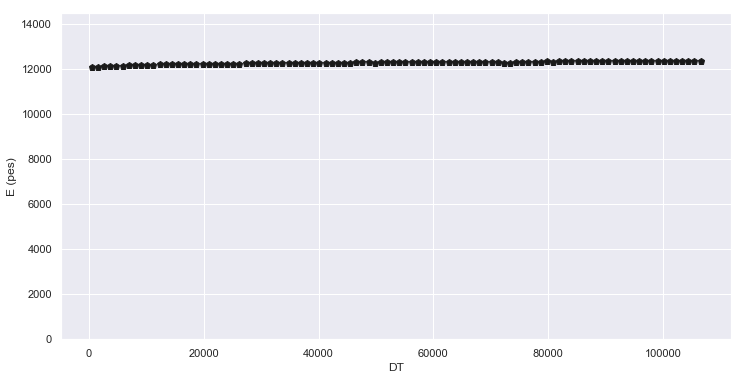

In [267]:
energy_X_profile(kse.DT, kse.E, xnbins = 100, xrange=(kse.DT[0], kse.DT[-1]), xlabel = 'DT',
                 erange=e_range,   
                 figsize=(12,6))

#### Everything is flat. No need for further corrections. 

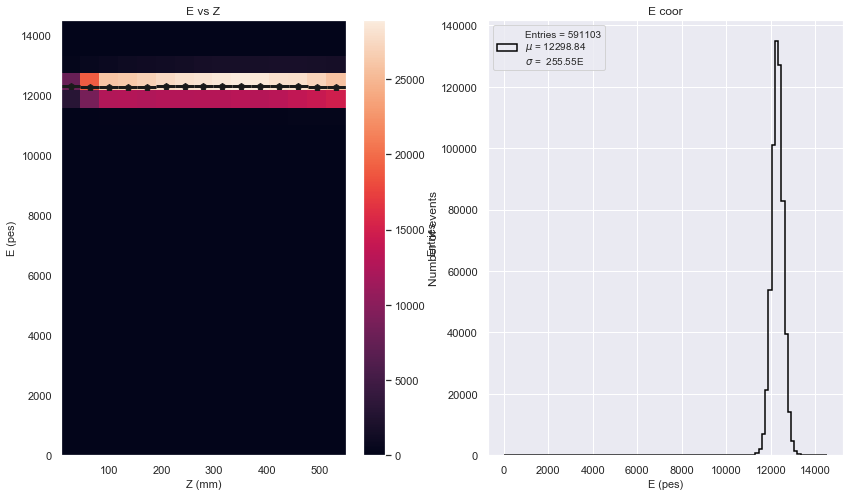

In [268]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(kse.Z, kse.E, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(kse.E,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12298.054694483892 +-0.32910231879552426 
 E sigma   = 249.2998226003527 +-0.25236358899154426 
 chi2    = 4.464054330820716 
 sigma E/E (FWHM)     (%) =4.763798809364584
 sigma E/E (FWHM) Qbb (%) =0.6152539358590146 


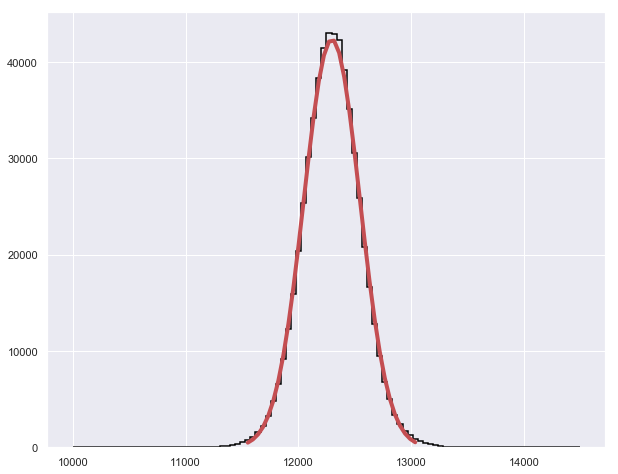

In [269]:
fc = fit_energy(kse.E, nbins=100, range=(10000, 14500))
plot_fit_energy(fc)
print_fit_energy(fc)

 fit failed for seed  = GaussPar(mu=Measurement(value=12286.185364729852, uncertainty=3.2065788082844744), std=Measurement(value=212.67620348501197, uncertainty=2.267651380632277), amp=Measurement(value=2393.0023584739142, uncertainty=5.68415906769889)), due to RunTimeWarning, retry fit 


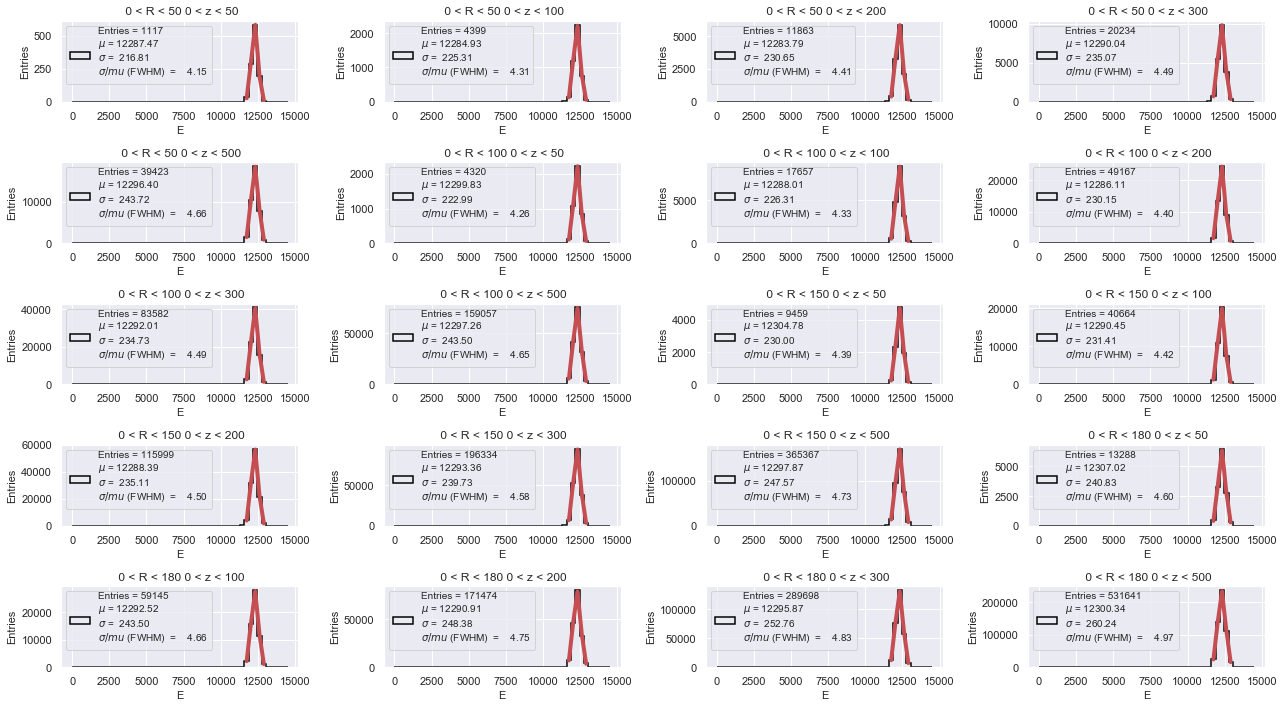

In [270]:
Ri = (50, 100,150,180)
Zi = (50, 100,200,300,500)

FC, FCE = resolution_r_z(Ri, Zi, kse.R, kse.Z, kse.E,
                    enbins = 50,
                    erange = e_range,
                    ixy = (5,4),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10)) 

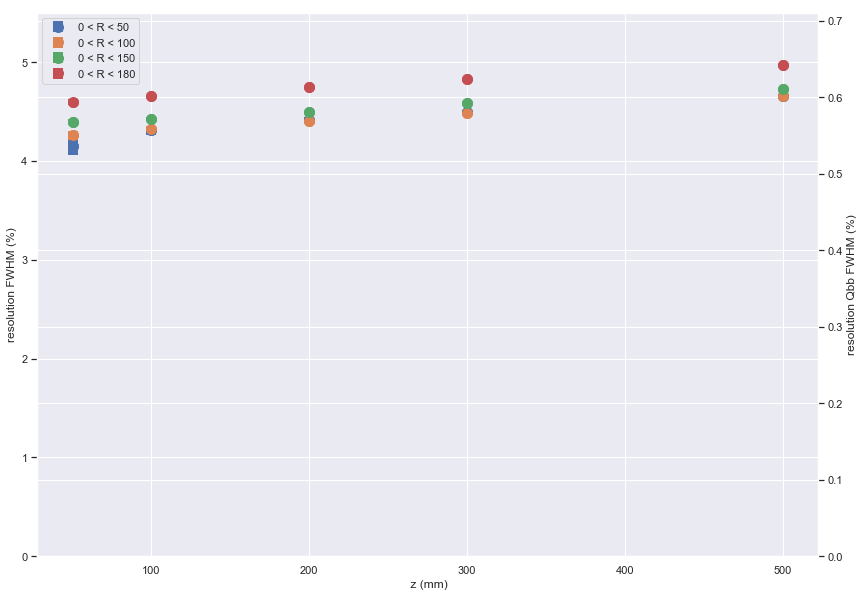

In [271]:
plot_resolution_r_z(Ri, Zi, FC, FCE, r_range=(0,5.5))

## On energy corrections as a function of time
- The analysis of this run shows that if lifetime does not change too much with time within a run (e.g, 24 hours), time-dependent corrections may not be needed.

## Does correction improve using a more precise energy map?

### Trying to use geometrical map from runs 6349_6353

In [272]:
emap_path = '/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_emap_xy_6349_6353.h5'

In [273]:
emaps = read_maps(filename=emap_path)

KeyError: 'No object named mapinfo in the file'

In [ ]:
draw_xy_maps(emaps,
            e0lims  = (7000, 14000),
            ltlims  = (3000, 4500),
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

In [ ]:
norm = amap_max(emaps)

In [ ]:
ti = timeit(e0_xy_correction)
E1 = ti(dst.S2e.values,
        dst.X.values,
        dst.Y.values,
        E0M = emaps.e0 / norm.e0, 
        xr  = krRanges.X,
        yr  = krRanges.Y,
        nx  = krNbins.X, 
        ny  = krNbins.Y)

In [ ]:
ti = timeit(lt_xy_correction)
E2 = ti(E1, 
       dst.X.values, 
       dst.Y.values,
       dst.Z.values, 
       LTM = emaps.lt,
       xr  = krRanges.X,
       yr  = krRanges.Y,
       nx  = krNbins.X, 
       ny  = krNbins.Y)



In [ ]:
kse2 = kr_event(dst, DT, E2, dst.S2q, sel)  # kse = krypton selected event

In [ ]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(kse2.Z, kse2.E, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(kse2.E,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

In [ ]:
fc = fit_energy(kse2.E, nbins=100, range=(12000, 13500))
plot_fit_energy(fc)
print_fit_energy(fc)

#### No substantial change using a high resolution energy map

## Outlook:

- Analysis of run shows that the simple strategy of 100 x 100 xy bin maps with no time dependence its enough to correct energy resolution.
- All dependences appear flat (for R < 180 cm).
- Resolution well behaved as a function of R and Z.
- In spite of fluctuation in lifetime with t, average value seems enough to achieve flat energy as a function of t and z.
- High statistics E0 map doest not improve (or worsen) resolution. 